LE QUERNEC Loévan, EL HACHEM Gabriel, and FALCK Jade, DIA2

# BI & DataViz / Machine learning for CV project: Human Action Recognition (HAR)

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Illustration of the problem

## Data visualization

## Methodology

## Computational results

In [2]:
# define the paths
train_dir = 'train'
test_dir = 'test'
train_csv = 'training_set.csv' # file with labeled data
test_csv = 'testing_set.csv' # file with unlabeled data

In [3]:
import pandas as pd

# load the data
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

### Extraction of caracteristics

Now we will encode the labels of the actions to integers. This will allow us to use them in the model. We will be able to retrieve the original labels with the variable `label_mapping`.

In [4]:
# encode the labels
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_df['label_idx'] = train_df['label'].map(label_mapping)

In [5]:
print(label_mapping)

{'sitting': 0, 'using_laptop': 1, 'hugging': 2, 'sleeping': 3, 'drinking': 4, 'clapping': 5, 'dancing': 6, 'cycling': 7, 'calling': 8, 'laughing': 9, 'eating': 10, 'fighting': 11, 'listening_to_music': 12, 'running': 13, 'texting': 14}


In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_width, img_height = 128, 128 # dimensions of our images

# prepare the training data
def load_images_from_dataframe(df, directory, img_width, img_height):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(directory, row['filename'])
        if os.path.exists(img_path):
            # load and rescale the image
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0 # normalize
            images.append(img_array)
            if 'label_idx' in row:
                labels.append(row['label_idx'])
    return np.array(images), np.array(labels)

In [7]:
from tensorflow.keras.utils import to_categorical

# load the traing images
X_train, y_train = load_images_from_dataframe(train_df, train_dir, img_width, img_height)
y_train = to_categorical(y_train, num_classes=len(label_mapping))

In [8]:
# load the test images
X_test, _ = load_images_from_dataframe(test_df, test_dir, img_width, img_height)

### Training

Specify the model(s) you want to launch the training and create a model file:

In [9]:
cnn = 0
vit = 0
mobilenet = 0

# hyperparameters
batch_size = 32
epochs = 10

In [10]:
if cnn:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

    # build a simple CNN
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(label_mapping), activation='softmax')
    ])

    # compile the model
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # train the model
    cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

    # save the model
    cnn_model.save('cnn_model.h5')

In [11]:
if vit:
    from transformers import ViTForImageClassification, ViTFeatureExtractor
    from PIL import Image
    import torch

    # Charger le modèle pré-entraîné
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

    # Modifier la fonction preprocess_images pour gérer les fichiers en batchs
    def preprocess_images(image_paths, batch_size=100):
        features = []
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = [Image.open(img_path).convert("RGB") for img_path in batch_paths]
            batch_features = feature_extractor(images=batch_images, return_tensors="pt").pixel_values
            features.append(batch_features)
            # Fermer les fichiers ouverts
            for img in batch_images:
                img.close()
        return torch.cat(features)

    # Prétraitement des images d'entraînement
    train_image_paths = [os.path.join(train_dir, fname) for fname in train_df['filename']]
    train_inputs = preprocess_images(train_image_paths, batch_size=100)

    # Assurez-vous que les labels correspondent
    train_labels = torch.tensor(train_df['label_idx'].values)

    # Fine-tuning
    from torch.utils.data import DataLoader, TensorDataset
    from transformers import AdamW

    # Créez le dataset avec les tenseurs
    dataset = TensorDataset(train_inputs, train_labels)  # train_inputs est déjà au bon format
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Configurer l'optimiseur
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Entraînement simplifié
    for epoch in range(5):  # Boucle sur les époques
        total_loss = 0
        for batch in train_loader:
            inputs, labels = batch  # Récupérer les entrées et labels
            outputs = model(pixel_values=inputs, labels=labels)  # Forward pass
            loss = outputs.loss  # Calcul de la perte
            loss.backward()  # Rétropropagation
            optimizer.step()  # Mise à jour des poids
            optimizer.zero_grad()  # Réinitialiser les gradients
            total_loss += loss.item()  # Ajouter la perte à la somme totale
        
        print(f"Epoch {epoch + 1} - Loss: {total_loss / len(train_loader)}")  # Afficher la perte moyenne par époque

    # Sauvegarder le modèle
    model.save_pretrained('vit_model')

In [12]:
if mobilenet:
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

    # load the base model MobileNetV2 pre-trained
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(len(label_mapping), activation='softmax')(x)

    # create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

    # save the model
    model.save('mobilenet_model.h5')

### Predictions

Select the model you want to use to make the predictions and have the results:

In [13]:
model_to_use = 'cnn'

In [14]:
import tensorflow as tf

# load the model
model = tf.keras.models.load_model(f'{model_to_use}_model.h5')

In [15]:
# make the predictions
train_predictions = model.predict(X_train)
train_predicted_labels = [list(label_mapping.keys())[np.argmax(pred)] for pred in train_predictions]

394/394 [==============================] - 18s 44ms/step


In [16]:
# make the predictions
test_predictions = model.predict(X_test)
test_predicted_labels = [list(label_mapping.keys())[np.argmax(pred)] for pred in test_predictions]

169/169 [==============================] - 9s 55ms/step


### Results

In [17]:
# calculate the accuracy on the training set
true_train_labels = [list(label_mapping.keys())[label] for label in np.argmax(y_train, axis=1)]
correct_predictions = sum(pred == true for pred, true in zip(train_predicted_labels, true_train_labels))
train_accuracy = correct_predictions / len(true_train_labels) * 100

print(f"Accuracy on the training set: {train_accuracy:.2f}%")

Accuracy on the training set: 79.32%


In [18]:
import matplotlib.pyplot as plt

# function to display images with predictions and true labels
def display_images_with_predictions_and_true_labels(images, predictions, true_labels, num_images=10):
    # limit the number of images
    num_images = min(num_images, len(images))
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(2, 5, i + 1) # 2 rows, 5 columns
        plt.imshow(images[i])
        plt.axis('off')
        
        # compare the prediction with the true label
        predicted_label = predictions[i]
        true_label = true_labels[i]
        color = "green" if predicted_label == true_label else "red"
        
        # add the title and the color
        plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}", color=color, fontsize=12)
    
    plt.tight_layout()
    plt.show()

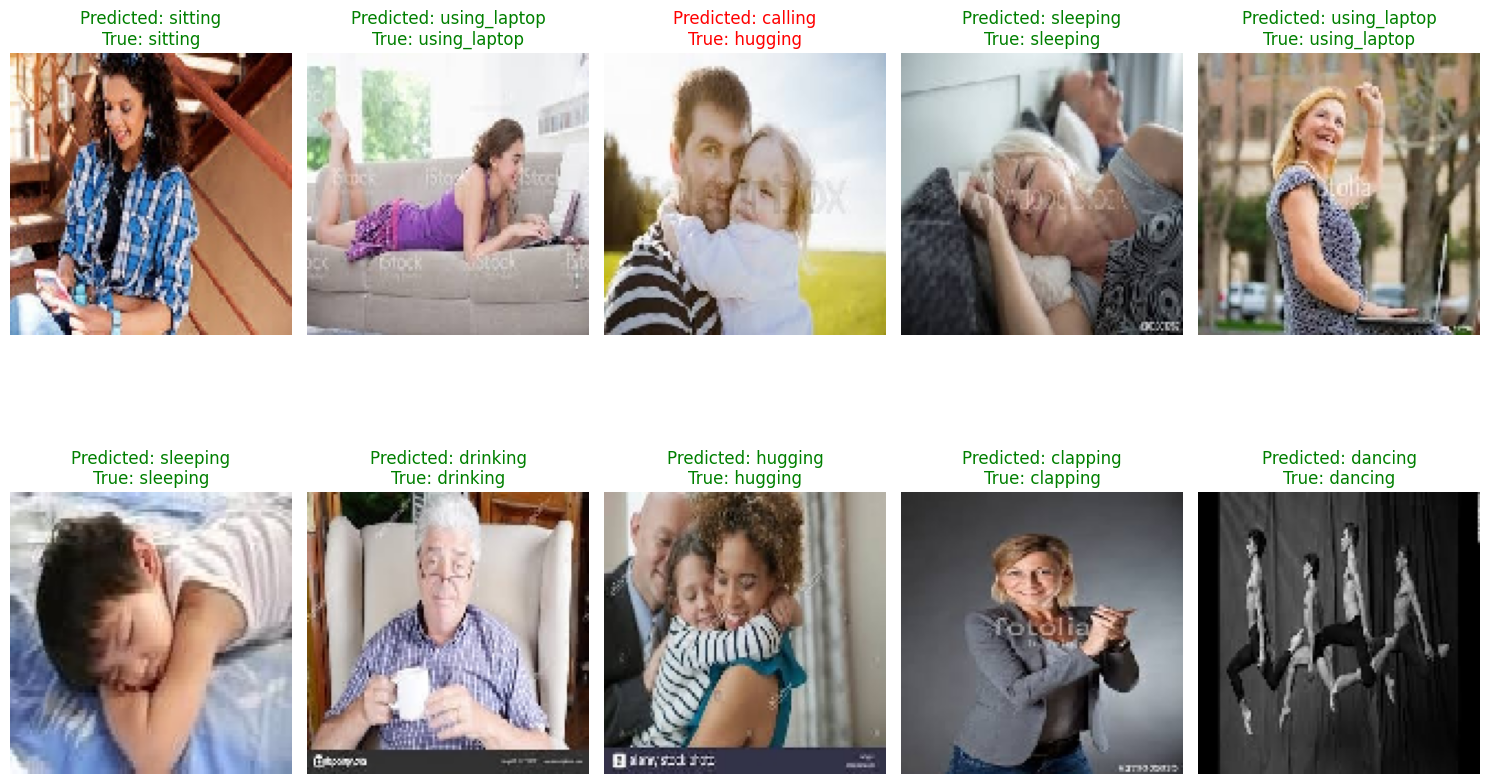

In [19]:
X_train_display = (X_train * 255).astype(np.uint8) # convert back to 0-255 range

# print the first 10 images with predictions and true labels
display_images_with_predictions_and_true_labels(
    images=X_train_display[:10],
    predictions=train_predicted_labels[:10],
    true_labels=true_train_labels
)

In [20]:
# function to display images with predictions
def display_images_with_predictions(images, predictions, num_images=10):
    # limit the number of images
    num_images = min(num_images, len(images))
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(2, 5, i + 1) # 2 rows, 5 columns
        plt.imshow(images[i])
        plt.axis('off')

        plt.title(f"Predicted: {predictions[i]}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

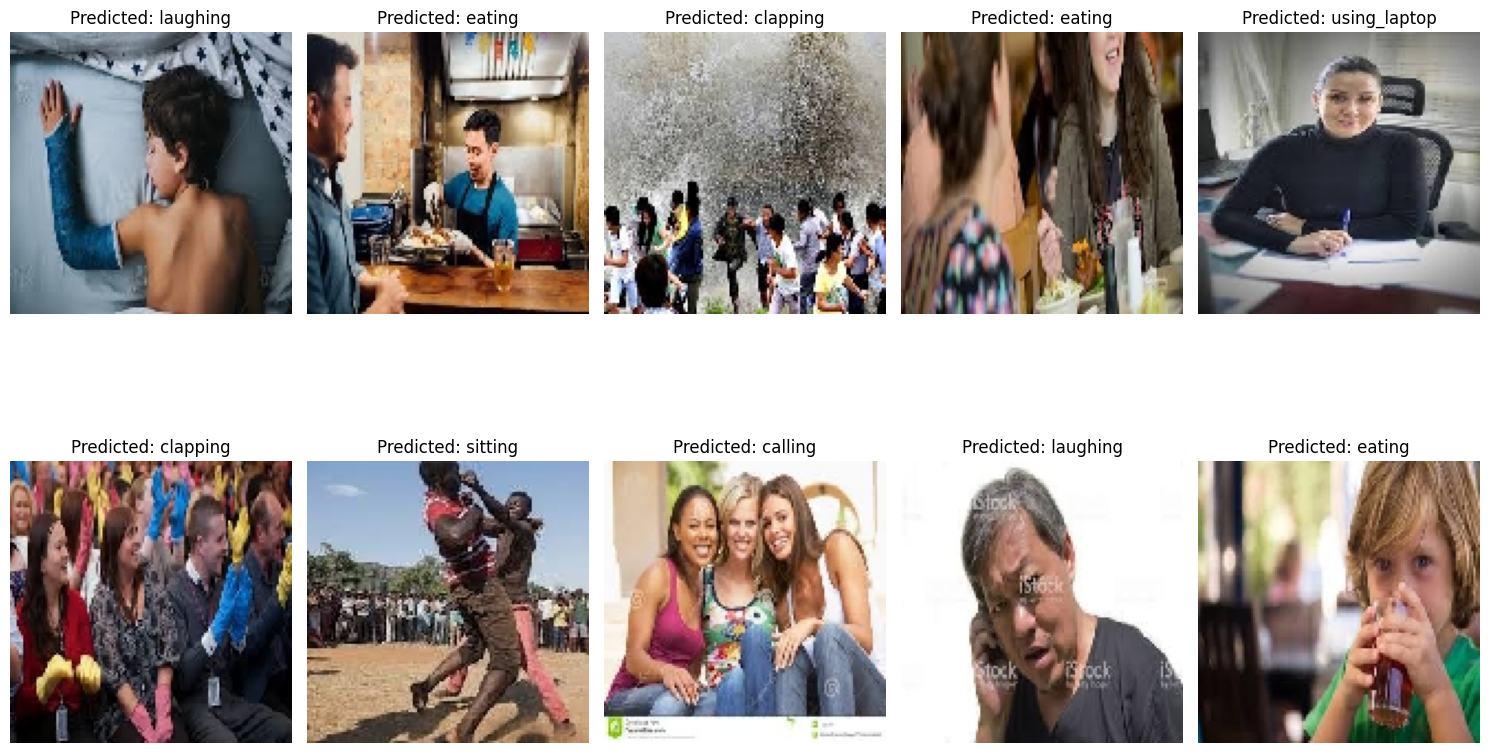

In [21]:
X_test_display = (X_test * 255).astype(np.uint8) # convert back to 0-255 range

# print the first 10 images with predictions
display_images_with_predictions(
    images=X_test_display[:10],
    predictions=test_predicted_labels[:10]
)

## Analysis and interpretation